In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, accuracy_score, classification_report, auc, log_loss
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from tpot import TPOTClassifier

warnings.filterwarnings("ignore")

%matplotlib inline

# Exploração dados de test

In [2]:
test = pd.read_csv('test.csv')

In [3]:
test.head()

,NU_INSCRICAO,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,...,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q002,Q006,Q024,Q025,Q026,Q027,Q047
0,ba0cc30ba34e7a46764c09dfc38ed83d15828897,43,RS,19,F,1,1,1,3,1,...,NaN,NaN,E,E,H,B,B,C,D,A
1,177f281c68fa032aedbd842a745da68490926cd2,15,PA,24,M,3,2,1,4,1,...,NaN,NaN,B,C,B,A,A,C,D,A
2,6cf0d8b97597d7625cdedc7bdb6c0f052286c334,29,BA,16,F,2,1,3,0,1,...,NaN,NaN,E,F,G,B,B,A,NaN,D
3,5c356d810fa57671402502cd0933e5601a2ebf1e,41,PR,17,F,1,1,2,0,2,...,40.0,480.0,E,E,E,C,B,B,C,A
4,df47c07bd881c2db3f38c6048bf77c132ad0ceb3,53,DF,19,F,1,1,1,1,1,...,80.0,720.0,E,E,E,B,B,B,D,A


In [4]:
train = pd.read_csv('train.csv')

In [5]:
# Funções locais

def cria_df_aux(df):
    df_aux = pd.DataFrame({
        'Columns': df.columns,
        'Type': df.dtypes,
        'Quantity': df.count(axis = 0),
        'Unique': df.nunique(),
        'Nan': df.isnull().sum()
    })
    df_aux['Nan_%'] = round(df_aux.Nan/df.shape[0]*100,2)
    return df_aux

def matriz_correlation(df, null = False):
    if null:
        corr = df.isnull().corr()
        cols = corr.columns[corr.count()>1]
        corr = corr.loc[cols, cols]
    else:
        corr = df.corr()
    cmap = sns.diverging_palette(20,220,n=200)
    mask = np.triu(np.ones(corr.shape)).astype(np.bool)
    sns.heatmap(corr, cmap = cmap, mask = mask, annot=True, vmin=-1, vmax=1, fmt='.2f')

def graph_ROC(probs, roc):
    preds = probs[:,1]
    fpr, tpr, threshold = roc
    roc_auc = auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [6]:
test_aux = cria_df_aux(test)
train_aux = cria_df_aux(train)

In [7]:
test_aux

,Columns,Type,Quantity,Unique,Nan,Nan_%
NU_INSCRICAO,NU_INSCRICAO,object,4570,4570,0,0.00
CO_UF_RESIDENCIA,CO_UF_RESIDENCIA,int64,4570,27,0,0.00
SG_UF_RESIDENCIA,SG_UF_RESIDENCIA,object,4570,27,0,0.00
NU_IDADE,NU_IDADE,int64,4570,47,0,0.00
TP_SEXO,TP_SEXO,object,4570,2,0,0.00
TP_COR_RACA,TP_COR_RACA,int64,4570,6,0,0.00
TP_NACIONALIDADE,TP_NACIONALIDADE,int64,4570,5,0,0.00
TP_ST_CONCLUSAO,TP_ST_CONCLUSAO,int64,4570,4,0,0.00
TP_ANO_CONCLUIU,TP_ANO_CONCLUIU,int64,4570,11,0,0.00
TP_ESCOLA,TP_ESCOLA,int64,4570,4,0,0.00


In [8]:
# Validar alunos que tiveram presença nas provas estão com Nan
print(test.loc[test.NU_NOTA_CN.isnull(),'TP_PRESENCA_CN'].value_counts())
print(test.loc[test.NU_NOTA_CH.isnull(),'TP_PRESENCA_CH'].value_counts())
print(test.loc[test.NU_NOTA_LC.isnull(),'TP_PRESENCA_LC'].value_counts())

0    1112
Name: TP_PRESENCA_CN, dtype: int64
0    1112
Name: TP_PRESENCA_CH, dtype: int64
0    1165
2       5
Name: TP_PRESENCA_LC, dtype: int64


In [9]:
# Atualizar notas para 0 
test.NU_NOTA_CN = test.NU_NOTA_CN.fillna(0)
test.NU_NOTA_CH = test.NU_NOTA_CH.fillna(0)
test.NU_NOTA_LC = test.NU_NOTA_LC.fillna(0)

In [10]:
test_aux = cria_df_aux(test)
test_aux

,Columns,Type,Quantity,Unique,Nan,Nan_%
NU_INSCRICAO,NU_INSCRICAO,object,4570,4570,0,0.00
CO_UF_RESIDENCIA,CO_UF_RESIDENCIA,int64,4570,27,0,0.00
SG_UF_RESIDENCIA,SG_UF_RESIDENCIA,object,4570,27,0,0.00
NU_IDADE,NU_IDADE,int64,4570,47,0,0.00
TP_SEXO,TP_SEXO,object,4570,2,0,0.00
TP_COR_RACA,TP_COR_RACA,int64,4570,6,0,0.00
TP_NACIONALIDADE,TP_NACIONALIDADE,int64,4570,5,0,0.00
TP_ST_CONCLUSAO,TP_ST_CONCLUSAO,int64,4570,4,0,0.00
TP_ANO_CONCLUIU,TP_ANO_CONCLUIU,int64,4570,11,0,0.00
TP_ESCOLA,TP_ESCOLA,int64,4570,4,0,0.00


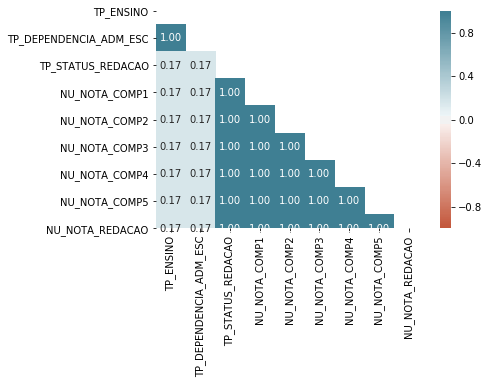

In [11]:
# Correlaçao entre as colunas numéricas que continuam com dados nulos
# Deixaremos a avaliação do que fazer com estes dados quando tivermos o modelo pronto
matriz_correlation(test.select_dtypes(exclude=object),null = True)

In [12]:
columns_work = list(test.columns)

# Exploração dos dados de treino

In [13]:
train = pd.read_csv('train.csv')

In [14]:
columns_work.append('IN_TREINEIRO')

In [15]:
train = train[columns_work]
train.head()

,NU_INSCRICAO,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,...,NU_NOTA_REDACAO,Q001,Q002,Q006,Q024,Q025,Q026,Q027,Q047,IN_TREINEIRO
0,ed50e8aaa58e7a806c337585efee9ca41f1eb1ad,43,RS,24,M,1,1,1,4,1,...,520.0,D,D,C,A,A,C,H,A,0
1,2c3acac4b33ec2b195d77e7c04a2d75727fad723,23,CE,17,F,3,1,2,0,2,...,580.0,A,A,B,A,A,A,NaN,A,0
2,f4545f8ccb9ff5c8aad7d32951b3f251a26e6568,23,CE,21,F,3,1,3,0,1,...,NaN,D,D,C,A,A,A,NaN,A,0
3,3d6ec248fef899c414e77f82d5c6d2bffbeaf7fe,33,RJ,25,F,0,1,1,9,1,...,NaN,H,E,E,C,B,C,F,D,0
4,bf896ac8d3ecadd6dba1dfbf50110afcbf5d3268,13,AM,28,M,2,1,1,4,1,...,NaN,E,D,C,A,A,B,F,A,0


In [16]:
train_aux = cria_df_aux(train)
train_aux

,Columns,Type,Quantity,Unique,Nan,Nan_%
NU_INSCRICAO,NU_INSCRICAO,object,13730,13730,0,0.00
CO_UF_RESIDENCIA,CO_UF_RESIDENCIA,int64,13730,27,0,0.00
SG_UF_RESIDENCIA,SG_UF_RESIDENCIA,object,13730,27,0,0.00
NU_IDADE,NU_IDADE,int64,13730,55,0,0.00
TP_SEXO,TP_SEXO,object,13730,2,0,0.00
TP_COR_RACA,TP_COR_RACA,int64,13730,6,0,0.00
TP_NACIONALIDADE,TP_NACIONALIDADE,int64,13730,5,0,0.00
TP_ST_CONCLUSAO,TP_ST_CONCLUSAO,int64,13730,4,0,0.00
TP_ANO_CONCLUIU,TP_ANO_CONCLUIU,int64,13730,11,0,0.00
TP_ESCOLA,TP_ESCOLA,int64,13730,4,0,0.00


In [17]:
# Validar alunos que tiveram presença nas provas estão com Nan
print(train.loc[train.NU_NOTA_CN.isnull(),'TP_PRESENCA_CN'].value_counts())
print(train.loc[train.NU_NOTA_CH.isnull(),'TP_PRESENCA_CH'].value_counts())
print(train.loc[train.NU_NOTA_LC.isnull(),'TP_PRESENCA_LC'].value_counts())

0    3380
2       9
Name: TP_PRESENCA_CN, dtype: int64
0    3380
2       9
Name: TP_PRESENCA_CH, dtype: int64
0    3592
2       5
Name: TP_PRESENCA_LC, dtype: int64


In [18]:
# Atualizar notas para 0 
train.NU_NOTA_CN = train.NU_NOTA_CN.fillna(0)
train.NU_NOTA_CH = train.NU_NOTA_CH.fillna(0)
train.NU_NOTA_LC = train.NU_NOTA_LC.fillna(0)

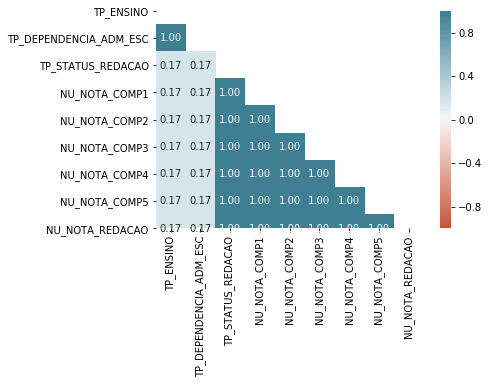

In [19]:
# Correlaçao entre as colunas numéricas que continuam com dados nulos
matriz_correlation(train.select_dtypes(exclude=object), null=True)

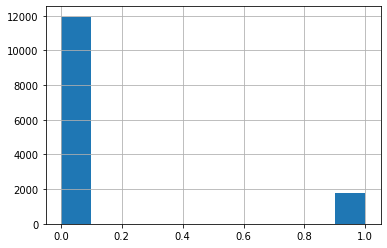

In [20]:
# Dados desbalanceados
train['IN_TREINEIRO'].hist()

### Considerações

- TP_DEPENDENCIA_ADM_ESC, TP_ENSINO e Q027 serão removidos do modelo por possuirem grande porcentagem de Nan
- IN_CEGUEIRA será removido por possuir somente um valor
- SG_UF_RESIDENCIA e CO_UF_RESIDENCIA são correlacionado. Será removido 'SG_UF_RESIDENCIA'
- IN_TREINEIRO baixa correlação com NU_NOTA_COMP1, NU_NOTA_COMP2, NU_NOTA_COMP3, NU_NOTA_COMP4, NU_NOTA_COMP5, TP_STATUS_REDACAO,NU_NOTA_REDACAO
- TP_PRESENCA_CN, TP_PRESENCA_CH, TP_PRESENCA_LC, TP_PRESENCA_MT possui correlação com as respectivas notas. Portanto serão mantidas somente as notas dos alunos
- 'Q024' e 'Q025' possuem correlação. Será removido 'Q024'
- NU_INSCRICAO será mantido mas não possui dados relevante ao modelo

In [21]:
columns =  ['IN_TREINEIRO', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'TP_STATUS_REDACAO', 'NU_NOTA_COMP1', 'NU_NOTA_COMP2',
       'NU_NOTA_COMP3', 'NU_NOTA_COMP4', 'NU_NOTA_COMP5', 'NU_NOTA_REDACAO']

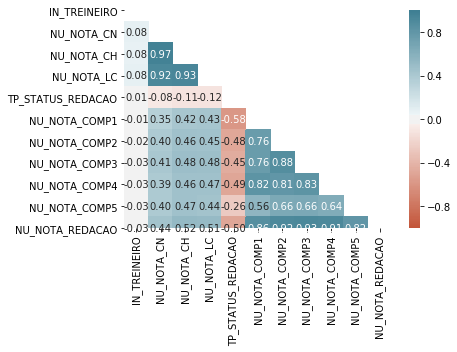

In [22]:
matriz_correlation(train[columns], null = False)

### Feature Engineering

In [23]:
#Juntar dados de treino e teste
df = pd.concat([train, test], keys=['train', 'test'], sort=False)

In [24]:
df.head()

NU_INSCRICAO  CO_UF_RESIDENCIA  \
train 0  ed50e8aaa58e7a806c337585efee9ca41f1eb1ad                43   
      1  2c3acac4b33ec2b195d77e7c04a2d75727fad723                23   
      2  f4545f8ccb9ff5c8aad7d32951b3f251a26e6568                23   
      3  3d6ec248fef899c414e77f82d5c6d2bffbeaf7fe                33   
      4  bf896ac8d3ecadd6dba1dfbf50110afcbf5d3268                13   

        SG_UF_RESIDENCIA  NU_IDADE TP_SEXO  TP_COR_RACA  TP_NACIONALIDADE  \
train 0               RS        24       M            1                 1   
      1               CE        17       F            3                 1   
      2               CE        21       F            3                 1   
      3               RJ        25       F            0                 1   
      4               AM        28       M            2                 1   

         TP_ST_CONCLUSAO  TP_ANO_CONCLUIU  TP_ESCOLA  ...  NU_NOTA_REDACAO  \
train 0                1                4          1  ...            520.0   
      1                2                0          2  ...            580.0   
      2                3                0          1  ...              NaN   
      3                1                9          1  ...              NaN   
      4                1                4          1  ...              NaN   

         Q001  Q002  Q006  Q024  Q025  Q026  Q027  Q047  IN_TREINEIRO  
train 0     D     D     C     A     A     C     H     A           0.0  
      1     A     A     B     A     A     A   NaN     A           0.0  
      2     D     D     C     A     A     A   NaN     A           0.0  
      3     H     E     E     C     B     C     F     D           0.0  
      4     E     D     C     A     A     B     F     A           0.0  

[5 rows x 44 columns]

In [25]:
# Frequência dos registros
# Devido a baixa frequência das colunas IN_SURDEZ, IN_DISLEXIA, IN_DISCALCULIA e IN_IDOSO, elas serã removidas do modelo 
columns = ['IN_BAIXA_VISAO', 'IN_SURDEZ', 'IN_DISLEXIA', 'IN_DISCALCULIA', 'IN_SABATISTA', 'IN_GESTANTE', 'IN_IDOSO']
for i in columns:
    print(df[i].value_counts())

0    18273
1       27
Name: IN_BAIXA_VISAO, dtype: int64
0    18295
1        5
Name: IN_SURDEZ, dtype: int64
0    18298
1        2
Name: IN_DISLEXIA, dtype: int64
0    18299
1        1
Name: IN_DISCALCULIA, dtype: int64
0    18126
1      174
Name: IN_SABATISTA, dtype: int64
0    18283
1       17
Name: IN_GESTANTE, dtype: int64
0    18297
1        3
Name: IN_IDOSO, dtype: int64


In [26]:
columns_drop = ['TP_DEPENDENCIA_ADM_ESC', 'TP_ENSINO', 'Q027', 'IN_CEGUEIRA', 'SG_UF_RESIDENCIA',
                'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4', 'NU_NOTA_COMP5', 
                'TP_STATUS_REDACAO', 'NU_NOTA_REDACAO', 'TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC',
                'TP_PRESENCA_MT', 'IN_SURDEZ', 'IN_DISLEXIA', 'IN_DISCALCULIA', 'IN_IDOSO', 'Q024'
               ]
df1 = df.drop(columns_drop, axis=1)

In [27]:
# Transformar dados categóricos com lab_enconder por ser mais variabilidade de valores únicos
df2 = df1.copy()
columns = ['Q001', 'Q002', 'Q006', 'Q047']
label_encoder =  LabelEncoder()
for i in columns:
        label_encoder.fit(df1[i])
        df2[i] = label_encoder.transform(df2[i])

In [28]:
# Transformar dados categóricos com get_dummies por ter pouca variabilidade
columns = ['TP_SEXO',  'Q025', 'Q026']
df2 = pd.get_dummies(df2, columns=columns)

In [29]:
df2.head()

NU_INSCRICAO  CO_UF_RESIDENCIA  NU_IDADE  \
train 0  ed50e8aaa58e7a806c337585efee9ca41f1eb1ad                43        24   
      1  2c3acac4b33ec2b195d77e7c04a2d75727fad723                23        17   
      2  f4545f8ccb9ff5c8aad7d32951b3f251a26e6568                23        21   
      3  3d6ec248fef899c414e77f82d5c6d2bffbeaf7fe                33        25   
      4  bf896ac8d3ecadd6dba1dfbf50110afcbf5d3268                13        28   

         TP_COR_RACA  TP_NACIONALIDADE  TP_ST_CONCLUSAO  TP_ANO_CONCLUIU  \
train 0            1                 1                1                4   
      1            3                 1                2                0   
      2            3                 1                3                0   
      3            0                 1                1                9   
      4            2                 1                1                4   

         TP_ESCOLA  IN_BAIXA_VISAO  IN_SABATISTA  ...  Q006  Q047  \
train 0          1               0             0  ...     2     0   
      1          2               0             0  ...     1     0   
      2          1               0             0  ...     2     0   
      3          1               0             0  ...     4     3   
      4          1               0             0  ...     2     0   

         IN_TREINEIRO  TP_SEXO_F  TP_SEXO_M  Q025_A  Q025_B  Q026_A  Q026_B  \
train 0           0.0          0          1       1       0       0       0   
      1           0.0          1          0       1       0       1       0   
      2           0.0          1          0       1       0       1       0   
      3           0.0          1          0       0       1       0       0   
      4           0.0          0          1       1       0       0       1   

         Q026_C  
train 0       1  
      1       0  
      2       0  
      3       1  
      4       0  

[5 rows x 27 columns]

### Modelos
- sem balanceamento e sem remover outliers
- com balanceamento e sem remover outliers
- com balanceamento, removendo outliers

In [30]:
X = df2.xs('train').drop(['IN_TREINEIRO','NU_INSCRICAO'] , axis=1)
y = df2.xs('train')['IN_TREINEIRO']

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=42 )

In [32]:
clf = LogisticRegression().fit(X_train, y_train)

In [33]:
predict = clf.predict(X_test)

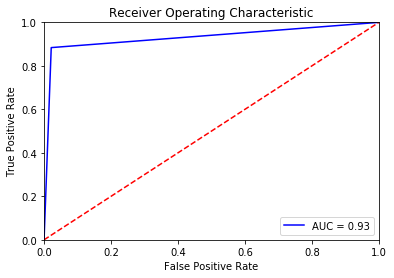

In [34]:
roc =roc_curve(y_test,predict )
probs = clf.predict_proba(X_test)
graph_ROC(probs, roc)

In [35]:
accuracy_score(y_test, predict)

0.9660119178989186

In [36]:
# Verifique que a precisão esta baixa na identificação dos Treineiros.
# Comportamente esperado para dados desbalanceados
print(classification_report(y_test, predict))

              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      3928
         1.0       0.86      0.88      0.87       603

    accuracy                           0.97      4531
   macro avg       0.92      0.93      0.93      4531
weighted avg       0.97      0.97      0.97      4531



### Oversampling
- copia da classe minoritária

In [56]:
X_resampled, y_resampled = SMOTE(random_state=42).fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.33, random_state=42)

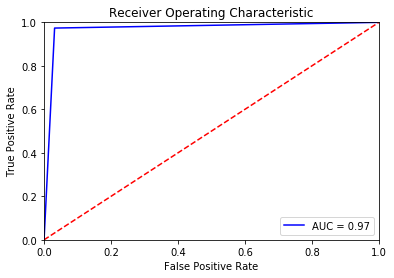

In [57]:
clf_over = LogisticRegression().fit(X_train, y_train)
predict = clf_over.predict(X_test)
roc =roc_curve(y_test,predict )
probs = clf.predict_proba(X_test)
graph_ROC(probs, roc)

In [58]:
print(classification_report(y_test, predict))

              precision    recall  f1-score   support

         0.0       0.98      0.97      0.97       605
         1.0       0.97      0.97      0.97       572

    accuracy                           0.97      1177
   macro avg       0.97      0.97      0.97      1177
weighted avg       0.97      0.97      0.97      1177



In [59]:
log_loss(y_test, predict)

0.9977345707545778

### Undersampling
Diminuição da classe majoritária

In [61]:
count_class_0, count_class_1 = df2.xs('train')['IN_TREINEIRO'].value_counts() #quantidade IN_TREINEIRO 0 e 1
df2_0 = df2.xs('train')[df2.xs('train')['IN_TREINEIRO']==0] # dataframe somente com IN_TREINEIRO =0 
df2_1 = df2.xs('train')[df2.xs('train')['IN_TREINEIRO']==1] # dataframe somente com IN_TREINEIRO =1

df2_0_under = df2_0.sample(count_class_1, random_state=42) # cria amostra do df2_0 com a quantidade de registro da classe menor
df2_under = pd.concat([df2_0_under, df2_1], axis=0)

In [62]:
df2_under['IN_TREINEIRO'].value_counts()
df2_under.columns

Index(['NU_INSCRICAO', 'CO_UF_RESIDENCIA', 'NU_IDADE', 'TP_COR_RACA',
       'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU', 'TP_ESCOLA',
       'IN_BAIXA_VISAO', 'IN_SABATISTA', 'IN_GESTANTE', 'NU_NOTA_CN',
       'NU_NOTA_CH', 'NU_NOTA_LC', 'TP_LINGUA', 'Q001', 'Q002', 'Q006', 'Q047',
       'IN_TREINEIRO', 'TP_SEXO_F', 'TP_SEXO_M', 'Q025_A', 'Q025_B', 'Q026_A',
       'Q026_B', 'Q026_C'],
      dtype='object')

In [63]:
X = df2_under.drop(['IN_TREINEIRO','NU_INSCRICAO'] , axis=1)
y = df2_under['IN_TREINEIRO']

In [64]:
df2_under.shape


(3566, 27)

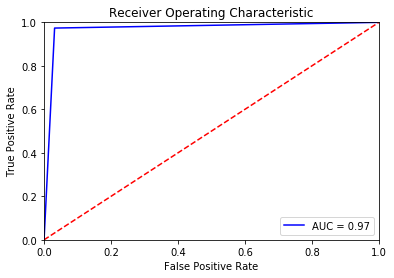

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=42 )
clf_under = LogisticRegression().fit(X_train, y_train)
predict = clf_under.predict(X_test)
roc =roc_curve(y_test,predict )
probs = clf.predict_proba(X_test)
graph_ROC(probs, roc)

In [66]:
print(classification_report(y_test, predict))

              precision    recall  f1-score   support

         0.0       0.98      0.97      0.97       605
         1.0       0.97      0.97      0.97       572

    accuracy                           0.97      1177
   macro avg       0.97      0.97      0.97      1177
weighted avg       0.97      0.97      0.97      1177



In [67]:
log_loss(y_test, predict)

0.9977345707545778

### GridSearch com Oversampling


In [46]:
X_resampled.shape


(23894, 25)

In [68]:
parameters = {'solver':('newton-cg', 'sag','lbfgs' ), 'C':[1, 10]}
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.33, random_state=42)
clf_over = LogisticRegression()
clf_grid = GridSearchCV(clf_over, parameters)
clf_grid.fit(X_train, y_train)


GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [1, 10], 'solver': ('newton-cg', 'sag', 'lbfgs')})

In [69]:
best_grid = clf_grid.best_estimator_

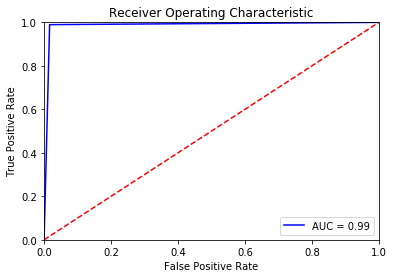

In [70]:
predict = best_grid.predict(X_test)
roc =roc_curve(y_test,predict )
probs = clf.predict_proba(X_test)
graph_ROC(probs, roc)

In [71]:
print(classification_report(y_test, predict))

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99       605
         1.0       0.98      0.99      0.99       572

    accuracy                           0.99      1177
   macro avg       0.99      0.99      0.99      1177
weighted avg       0.99      0.99      0.99      1177



In [72]:
log_loss(y_test, predict)

0.46952287025732703

### TPOT - AutoML

In [74]:
#Teste pequeno para verificar o funcionamento do TPOT. Embora tenha baixado o log_loss,
#o score no desafio caiu para 98.993%
tpot = TPOTClassifier( generations=5, population_size=50, verbosity=2)
tpot.fit(X_train, y_train)


Generation 1 - Current best internal CV score: 0.993305439330544
Generation 2 - Current best internal CV score: 0.993305439330544
Generation 3 - Current best internal CV score: 0.993305439330544
Generation 4 - Current best internal CV score: 0.993305439330544
Generation 5 - Current best internal CV score: 0.993305439330544
Best pipeline: XGBClassifier(input_matrix, learning_rate=1.0, max_depth=5, min_child_weight=2, n_estimators=100, nthread=1, subsample=0.8)


TPOTClassifier(generations=5,
               log_file=<colorama.ansitowin32.StreamWrapper object at 0x000001AAEDFFB488>,
               population_size=50, verbosity=2)

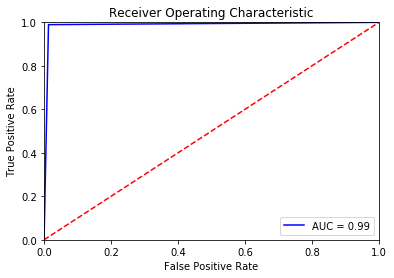

In [76]:
predict = tpot.predict(X_test)
roc =roc_curve(y_test,predict )
probs = clf.predict_proba(X_test)
graph_ROC(probs, roc)

In [77]:
print(classification_report(y_test, predict))

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       605
         1.0       0.99      0.99      0.99       572

    accuracy                           0.99      1177
   macro avg       0.99      0.99      0.99      1177
weighted avg       0.99      0.99      0.99      1177



In [78]:
#Log loss quanto menor melhor. Quanto mais próximo a zero maior é a proporção do evento ocorrer na vida real.
log_loss(y_test, predict)

0.4108320019610809

### Arquivo para submissão

In [51]:
df2.columns

Index(['NU_INSCRICAO', 'CO_UF_RESIDENCIA', 'NU_IDADE', 'TP_COR_RACA',
       'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU', 'TP_ESCOLA',
       'IN_BAIXA_VISAO', 'IN_SABATISTA', 'IN_GESTANTE', 'NU_NOTA_CN',
       'NU_NOTA_CH', 'NU_NOTA_LC', 'TP_LINGUA', 'Q001', 'Q002', 'Q006', 'Q047',
       'IN_TREINEIRO', 'TP_SEXO_F', 'TP_SEXO_M', 'Q025_A', 'Q025_B', 'Q026_A',
       'Q026_B', 'Q026_C'],
      dtype='object')

In [79]:
colunas = df2.drop(['IN_TREINEIRO', 'NU_INSCRICAO'], axis=1).columns
df_entrega = df2.xs('test')[colunas]

In [80]:
#modelo_preds = best_grid.predict(df_entrega)
modelo_preds = tpot.predict(df_entrega)

In [81]:
df_submit = pd.DataFrame({
    'NU_INSCRICAO':df2.xs('test').NU_INSCRICAO,
    'IN_TREINEIRO':modelo_preds
})
df_submit.to_csv('answer.csv', index=False)